In [ ]:
#for reference: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/TemperatureSalinityDiagrams.ipynb

In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
display(client)

2022-08-24 10:39:20,005 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56287130.gadi-pbs/dask-worker-space/worker-e4bkk1gl', purging
2022-08-24 10:39:20,005 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56287130.gadi-pbs/dask-worker-space/worker-_04vka7y', purging
2022-08-24 10:39:20,005 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56287130.gadi-pbs/dask-worker-space/worker-96p4a607', purging
2022-08-24 10:39:20,005 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56287130.gadi-pbs/dask-worker-space/worker-3_kttagx', purging


<Client: 'tcp://127.0.0.1:43467' processes=4 threads=16, memory=180.00 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2155-01-01'

lat_slice = slice(-80,-59)
lon_slice = slice(-280,80)
#isobath_depth = 1000

In [4]:
# build database for basal melt experiments:
session_name = '/g/data/e14/hd4873/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

Get bathymetry. 

In [7]:
# get bathymetry
ht = cc.querying.getvar(control, 'ht', master_session, n=-1).sel(yt_ocean=lat_slice)

Define functions to read in data from control and simulation

In [37]:
def read_and_convert_TS(lat_slice, lon_slice, start_time, end_time):
    '''
    Reads T and S from control and Tfreeze_min simulation
    Restricts to shelf and region given by lat_slice and lon_slice
    Convert TS using gsw
    '''
    
    # control run
    temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    # temp_Tfreeze_min run
    temp_Tfreeze_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt_Tfreeze_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

    # subset temp and salinity only for shelf values and load.
    temp = temp.where(ht<1000)
    salt = salt.where(ht<1000)
    temp_Tfreeze_min = temp_Tfreeze_min.where(ht<1000)
    salt_Tfreeze_min = salt_Tfreeze_min.where(ht<1000)

    # subset for first region and load data
    temp = temp.load()
    salt = salt.load()
    temp_Tfreeze_min = temp_Tfreeze_min.load()
    salt_Tfreeze_min = salt_Tfreeze_min.load()
    print('Temp is' , temp.nbytes/1000**3, 'GB')
    
    # convert Temp to deg C
    temp = temp - 273.15
    temp_Tfreeze_min = temp_Tfreeze_min - 273.15
    # convert salinity to absolute salinity
    p = gsw.p_from_z(-salt.st_ocean,salt.yt_ocean)
    salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    salt_Tfreeze_min = gsw.SA_from_SP(salt_Tfreeze_min, p, salt_Tfreeze_min.xt_ocean, salt_Tfreeze_min.yt_ocean)
    
    return temp,salt,temp_Tfreeze_min,salt_Tfreeze_min


Define figure functions

In [50]:
def figure(region):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(1,2, figsize=(18,7))
    sig_lvls = [24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28]
    for ax in axes.flatten():
        ax.set_ylim([-2,5])
        ax.set_xlim([30,35])
        ax.set_ylabel('Temperature (C)')
        ax.set_xlabel('Absolute Salinity')
        cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='lightgrey',linewidths=1)
        ax.clabel(cl, sig_lvls)
        
    return fig, axes, region

def scatter_colour_array(salt, salt_Tfreeze_min):
    # create depth arrays for colouring scatter plot
    depth = salt.copy(deep=True)
    depth.rename('depth')
    for i in range(75):
        depth[:,i,:,:] = depth.st_ocean[i]
    depth_Tfreeze = salt_Tfreeze_min.copy(deep=True)
    depth_Tfreeze.rename('depth')
    for i in range(75):
        depth_Tfreeze[:,i,:,:] = depth_Tfreeze.st_ocean[i]

    # create latitude arrays for colouring scatter plot
    lat_arr = salt.copy(deep=True)
    lat_arr.rename('lat')
    for i in range(len(salt.yt_ocean)):
        lat_arr[:,:,i,:] = lat_arr.yt_ocean[i]
    lat_arr_Tfreeze = salt_Tfreeze_min.copy(deep=True)
    lat_arr_Tfreeze.rename('lat')
    for i in range(len(salt_Tfreeze_min.yt_ocean)):
        lat_arr_Tfreeze[:,:,i,:] = lat_arr_Tfreeze.yt_ocean[i]
        
    return depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze

# create density mesh for contours on T-S
temp_vals = np.arange(-2.5,5,.1)
salt_vals = np.arange(26,35.5,.01) 
temp_mesh,salt_mesh = np.meshgrid(temp_vals,salt_vals)
density_for_contouring = gsw.density.rho(salt_mesh, temp_mesh, 1) #- 1000
sigma0_for_contouring = gsw.density.sigma0(salt_mesh, temp_mesh)
sigma1_for_contouring = gsw.density.sigma1(salt_mesh, temp_mesh)

Quickly plot regions of interest for reference.

--> Probably want to restrict these much closer to coastline.

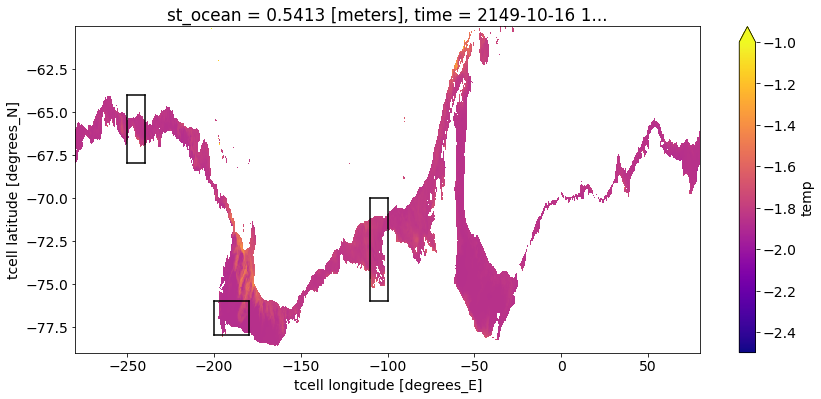

In [51]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'
lat_slice = slice(-79,-60)
lon_slice = slice(-280,80)
# read in T and S for region
temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp = temp.where(ht<1000)

# plot regions of interest for quick reference check
(temp[0,0,:,:]-273.15).plot(figsize=(14,6), cmap='plasma', vmin=-2.5, vmax=-1)
#amundsen
plt.plot([-110,-110],[-76,-70],c='k')
plt.plot([-100,-100],[-76,-70],c='k')
plt.plot([-110,-100],[-76,-76],c='k')
plt.plot([-110,-100],[-70,-70],c='k')
#ea
plt.plot([-250,-250],[-68,-64],c='k')
plt.plot([-240,-240],[-68,-64],c='k')
plt.plot([-250,-240],[-68,-68],c='k')
plt.plot([-250,-240],[-64,-64],c='k')
#ross sea
plt.plot([-200,-200],[-78,-76],c='k')
plt.plot([-180,-180],[-78,-76],c='k')
plt.plot([-200,-180],[-78,-78],c='k')
plt.plot([-200,-180],[-76,-76],c='k')
plt.show()

Now plot specific regions. 

### Amundsen Sea

In [52]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# Amundsen Sea region
lat_slice = slice(-76,-70)
lon_slice = slice(-110,-100)
# read in T and S for region
temp, salt, temp_Tfreeze_min, salt_Tfreeze_min = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = scatter_colour_array(salt, salt_Tfreeze_min)

Temp is 0.0639 GB


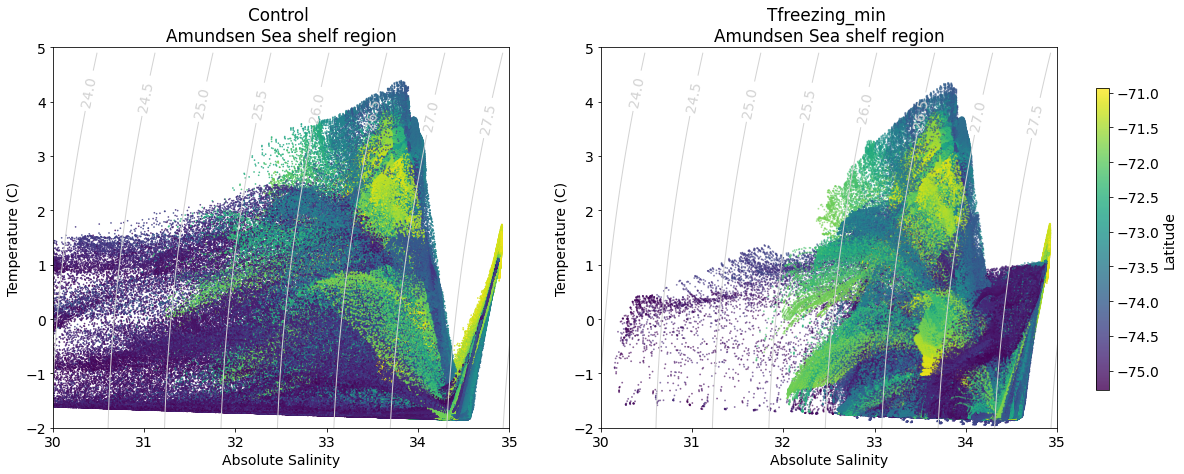

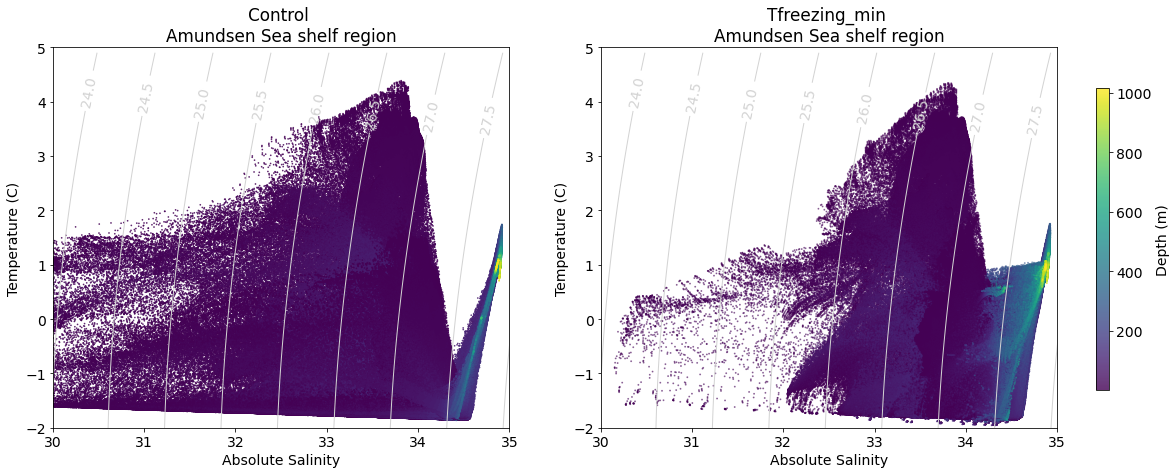

In [53]:
# plot figure
scatter_colour = ['lat','depth']

for f in range(2):
    fig, axes, region = figure('Amundsen Sea')
    
    if scatter_colour[f] == 'depth':
        c = axes[0].scatter(salt,temp, s=.5, c = depth, alpha=0.8)
        axes[1].scatter(salt_Tfreeze_min,temp_Tfreeze_min, c = depth_Tfreeze, s=.8, alpha=0.5)
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        c = axes[0].scatter(salt,temp, s=.5, c = lat_arr, alpha=0.8)
        axes[1].scatter(salt_Tfreeze_min,temp_Tfreeze_min, c = lat_arr_Tfreeze, s=.8, alpha=0.5)
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min \n{region} shelf region')

    plt.show()

### East Antarctic Section

In [54]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# East Antarctic region
lat_slice = slice(-68,-62)
lon_slice = slice(-250,-240)
# read in T and S for region
temp, salt, temp_Tfreeze_min, salt_Tfreeze_min = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = scatter_colour_array(salt, salt_Tfreeze_min)

Temp is 0.0621 GB


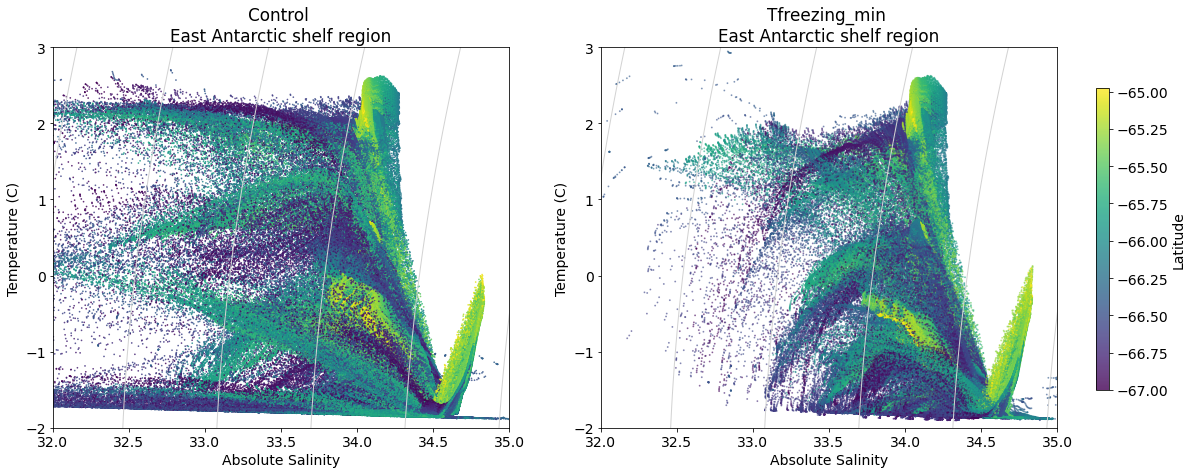

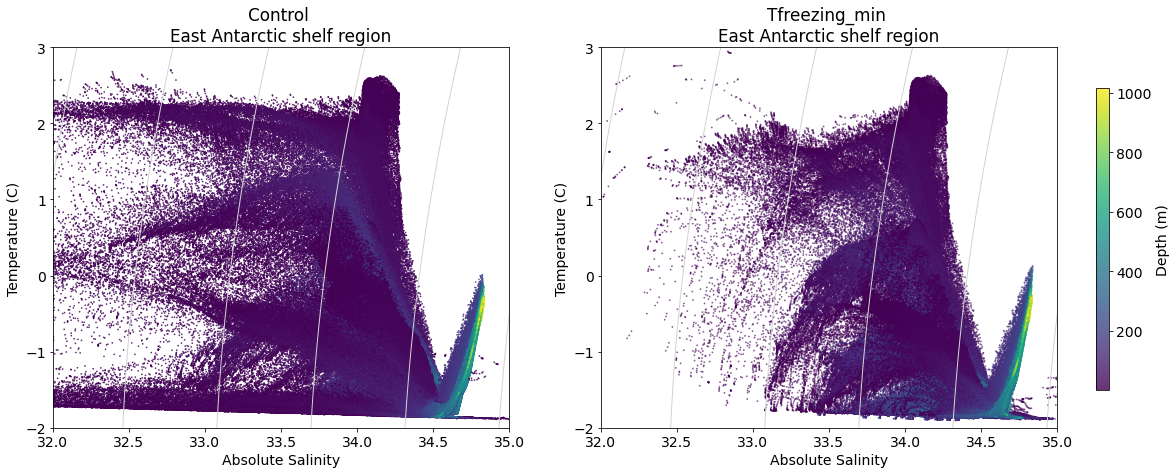

In [55]:
# plot figure
scatter_colour = ['lat','depth']

for f in range(2):
    fig, axes, region = figure('East Antarctic')
    
    if scatter_colour[f] == 'depth':
        c = axes[0].scatter(salt,temp, s=.5, c = depth, alpha=0.8)
        axes[1].scatter(salt_Tfreeze_min,temp_Tfreeze_min, c = depth_Tfreeze, s=.8, alpha=0.5)
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        c = axes[0].scatter(salt,temp, s=.5, c = lat_arr, alpha=0.8)
        axes[1].scatter(salt_Tfreeze_min,temp_Tfreeze_min, c = lat_arr_Tfreeze, s=.8, alpha=0.5)
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min \n{region} shelf region')
    for i in range(2):
        axes[i].set_ylim([-2,3])
        axes[i].set_xlim([32,35])

    plt.show()

### Ross Sea Section

In [56]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# East Antarctic region
lat_slice = slice(-78,-76)
lon_slice = slice(-200,-180)
# read in T and S for region
temp, salt, temp_Tfreeze_min, salt_Tfreeze_min = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = scatter_colour_array(salt, salt_Tfreeze_min)

Temp is 0.0423 GB


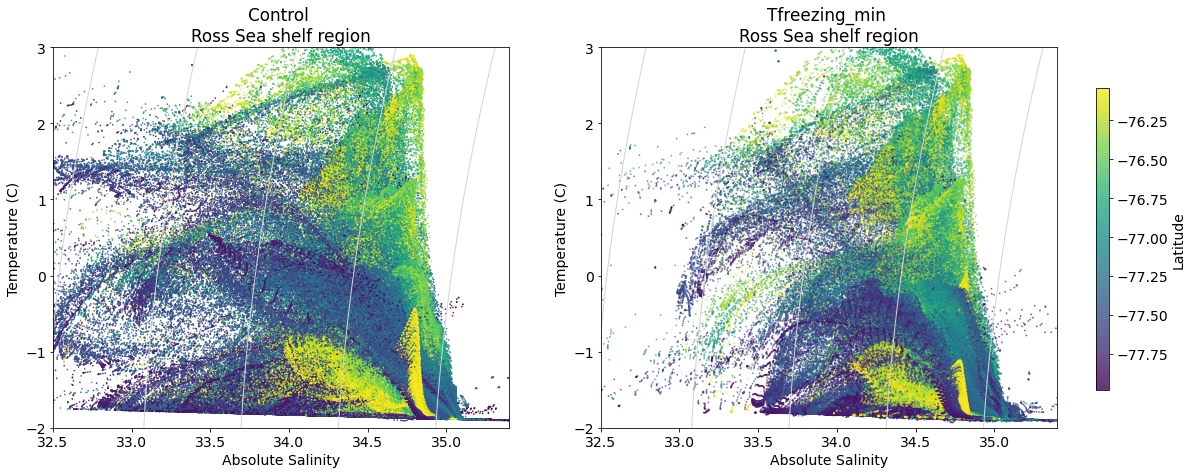

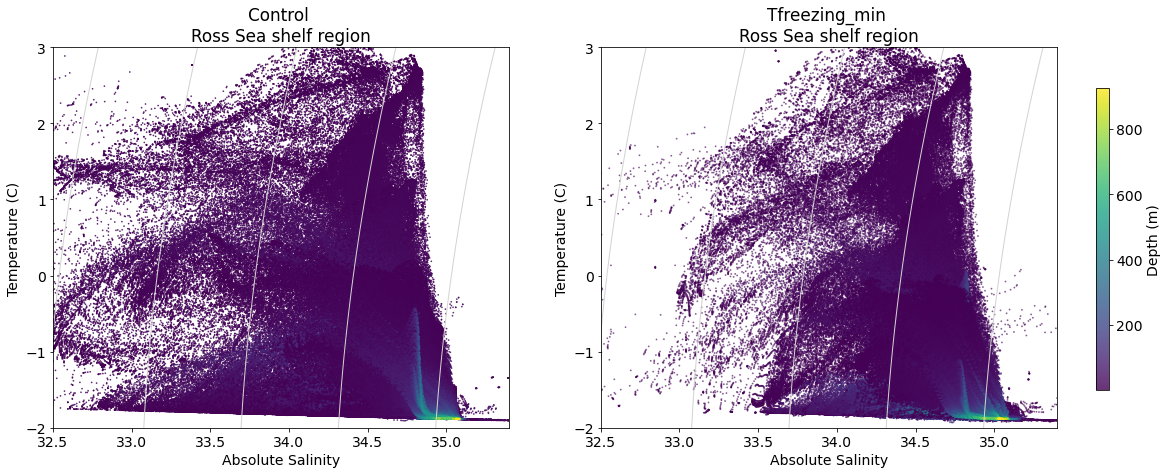

In [59]:
# plot figure
scatter_colour = ['lat','depth']

for f in range(2):
    fig, axes, region = figure('Ross Sea')
    
    if scatter_colour[f] == 'depth':
        c = axes[0].scatter(salt,temp, s=.5, c = depth, alpha=0.8)
        axes[1].scatter(salt_Tfreeze_min,temp_Tfreeze_min, c = depth_Tfreeze, s=.8, alpha=0.5)
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        c = axes[0].scatter(salt,temp, s=.5, c = lat_arr, alpha=0.8)
        axes[1].scatter(salt_Tfreeze_min,temp_Tfreeze_min, c = lat_arr_Tfreeze, s=.8, alpha=0.5)
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min \n{region} shelf region')
    for i in range(2):
        axes[i].set_ylim([-2,3])
        axes[i].set_xlim([32.5,35.4])

    plt.show()